# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Write the problem in your own words here

In [1]:
#import your libraries
# Import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sp
import sklearn.metrics as skm
from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer, StandardScaler, PolynomialFeatures 
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Authorship
__author__ = "Taesun Yoo"
__email__ = "yoots@gmail.com"

C:\Users\yoots\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Part 2 - DISCOVER

### ---- 2 Write a group of functions ----

In [2]:
# Write a group of functions:
def load_data(file):
    '''Load input file CSVs to dataframe'''
    return pd.read_csv(file)

def combine_data(df1, df2, key=None, left_index=False, right_index=False):
    '''Performs inner join on two dataframes and return records'''
    return pd.merge(left=df1, right=df2, how='inner', on=key,
                       left_index=left_index, right_index=right_index)

def clean_data(raw_df):
    '''Remove rows with duplicate jobId and invalid records'''
    cleaned_df = raw_df.drop_duplicates(subset='jobId')
    cleaned_df = cleaned_df[cleaned_df.salary>0]
    return cleaned_df

def check_missing_data(cleaned_df):
    missing_df = cleaned_df.isnull().sum()
    missing_df = pd.DataFrame(missing_df, columns=['count'])
    missing_df['pct'] = missing_df['count']/len(cleaned_df)
    missing_df = missing_df.sort_values(by='pct', ascending=False)
    return missing_df

def avg_groupby_data(cleaned_df, num_var, cat_var, avg_var_name):
    '''groupby categorical var to calculate an average numerical feature'''
    avg_groupby_cat_val = cleaned_df.groupby(cat_var)[num_var].mean().sort_values(ascending=False)
    avg_groupby_cat_df = pd.DataFrame({cat_var:list(cleaned_df[cat_var].unique()),
                                      avg_var_name:avg_groupby_cat_val})
    avg_groupby_cat_df.reset_index(drop=True, inplace=True)
    return avg_groupby_cat_df

def left_join_data(cleaned_df, avg_groupby_cat_df, key=None, left_index=False, right_index=False):
    '''Performs left join from cleaned dataframe to average groupby dataframe'''
    return pd.merge(left=cleaned_df, right=avg_groupby_cat_df, how='left',
                   left_index=left_index, right_index=right_index)

def drop_cat_feature_df(df, list_vars=None):
    '''Drop no-value added categorical features'''
    final_df = df.drop(list_vars, axis=1)
    return final_df

def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorical variables and combine
       results with numerical variables'''
    cat_df = pd.get_dummies(df[cat_vars], drop_first=True)
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)

def get_label_df(df, label):
    '''Returns label from dataframe'''
    return df[label]

def feat_selection_df(df, model, feat_name, Est_Coef, file_name):
    '''Creates L1 feature selected dataframe'''
    df_L1_select = pd.DataFrame({feat_name:df.columns, Est_Coef:model.coef_})[[feat_name, Est_Coef]]
    df_L1_select = df_L1_select.sort_values(by=Est_Coef, ascending=False)
    df_L1_select.to_excel(file_name)

def model_tuning_param(model, feature_df, label_df, param_dist, n_iter):
    '''Performs RandomizedSearchCV to tune model parameters'''
    random_search = RandomizedSearchCV(model, param_dist, n_iter, cv=2)
    random_search.fit(feature_df, label_df)
    return random_search

def print_best_params(random_search, param_1=None, param_2=None, param_3=None):
    '''Print the best model parameter'''
    print("Best " + param_1 + ":", random_search.best_estimator_.get_params()[param_1])
    print("Best " + param_1 + ":", random_search.best_estimator_.get_params()[param_2])
    print("Best " + param_1 + ":", random_search.best_estimator_.get_params()[param_3])

def model_train(model, feature_df, label_df, n_proc, mean_mse, cv_std):
    '''Train a model and output mean MSE and CV Std.Dev MSE'''
    neg_mse = cross_val_score(model, feature_df, label_df, n_jobs=n_proc, cv=2,
                              scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
    
def model_summary(model, mean_mse, cv_std):
    '''Print out the model perforamnces'''
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Std. Dev during CV:\n', cv_std[model])
    
def model_results(model, mean_mse, predictions, feature_importances):
    '''Saves the model name, mean_mse, predicted salaries, and feature importances'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
        feature_importances.to_csv('feat_importances.csv')
        np.savetxt('final_pred.csv', predictions, delimiter=',')

### ---- 3 Load the data ----

In [3]:
if __name__ == '__main__':
    #define input CSVs
    train_feature_file='C:/Users/yoots/Desktop/P_Salary_Prediction/train_features.csv'
    train_label_file='C:/Users/yoots/Desktop/P_Salary_Prediction/train_salaries.csv'
    test_feature_file='C:/Users/yoots/Desktop/P_Salary_Prediction/test_features.csv'
    
    #define variable lists
#    categorical_vars = ['jobId', 'companyId',  'jobType', 'degree', 'major', 'industry']
    categorical_vars = ['companyId',  'jobType', 'degree', 'major']
    numerical_vars = ['yearsExperience', 'milesFromMetropolis', 'avg_salary_industry', 'avg_yearsExp_industry', 
                      'avg_yearsExp_jobType','avg_dist_by_industry','avg_dist_by_jobType']
    label_var = 'salary'
    
    #define variables to drop
    list_vars = ['jobId', 'industry']
    
    #load data
    print("data loading")
    train_df = load_data(train_feature_file)
    label_df = load_data(train_label_file)
    test_df = load_data(test_feature_file)
    
    del(train_feature_file, train_label_file, test_feature_file)
    
    # combine train set
    train_raw_df = combine_data(train_df, label_df, key='jobId')

data loading


### ---- 4 Clean & feature engineer the data ----

In [4]:
#clean, shuffle, and reindex train data -- shuffling improves c-v accuracy
cleaned_df = shuffle(clean_data(train_raw_df)).reset_index(drop=True)
    
#---- 5 Engineer features ----#
# ensure data is ready for modeling
# create any new features needed to potentially enhance model

avg_salary_by_industry_df = avg_groupby_data(cleaned_df, 'salary', 'industry', 'avg_salary_industry')
avg_yearsExp_by_industry_df = avg_groupby_data(cleaned_df, 'yearsExperience', 'industry', 'avg_yearsExp_industry')
avg_yearsExp_by_jobType_df = avg_groupby_data(cleaned_df, 'yearsExperience', 'jobType', 'avg_yearsExp_jobType')
avg_dist_by_industry_df = avg_groupby_data(cleaned_df, 'milesFromMetropolis', 'industry', 'avg_dist_by_industry')   
avg_dist_by_jobType_df = avg_groupby_data(cleaned_df, 'milesFromMetropolis', 'jobType', 'avg_dist_by_jobType')
        
#perform left joins on avg_salary and train/test set:
joined_train_df = left_join_data(cleaned_df, avg_salary_by_industry_df, key='industry')    
joined_train_df = left_join_data(joined_train_df, avg_yearsExp_by_industry_df, key='industry')    
joined_train_df = left_join_data(joined_train_df, avg_yearsExp_by_jobType_df, key='jobType')    
joined_train_df = left_join_data(joined_train_df, avg_dist_by_industry_df, key='industry')    
joined_train_df = left_join_data(joined_train_df, avg_dist_by_jobType_df, key='jobType')    
   
joined_test_df = left_join_data(test_df, avg_salary_by_industry_df, key='industry')    
joined_test_df = left_join_data(joined_test_df, avg_yearsExp_by_industry_df, key='industry')    
joined_test_df = left_join_data(joined_test_df, avg_yearsExp_by_jobType_df, key='jobType')    
joined_test_df = left_join_data(joined_test_df, avg_dist_by_industry_df, key='industry')    
joined_test_df = left_join_data(joined_test_df, avg_dist_by_jobType_df, key='jobType')    
    
del(avg_salary_by_industry_df, avg_yearsExp_by_industry_df, avg_yearsExp_by_jobType_df,
    avg_dist_by_industry_df, avg_dist_by_jobType_df)    

### ---- 5 Explore the data (EDA) ----

In [5]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

### ---- 6 One-Hot-Encode Features ----

In [6]:
    # drop useless categorical features on train and test sets
    print("drop useless cat features")
    train_df = drop_cat_feature_df(joined_train_df, list_vars=list_vars)
    test_df = drop_cat_feature_df(joined_test_df, list_vars=list_vars)
    
    # one-hot encode categorical data on train and test sets
    print("encoding data")
    train_df = one_hot_encode_feature_df(train_df, cat_vars=categorical_vars, 
                                         num_vars=numerical_vars)
    test_df = one_hot_encode_feature_df(test_df, cat_vars=categorical_vars, 
                                         num_vars=numerical_vars)

    del(joined_train_df, joined_test_df)
    
    # get label df
    label_df = get_label_df(cleaned_df, label_var)

    del(cleaned_df)

drop useless cat features
encoding data


### ---- 6 Feature Selection/Importances ----

In [7]:
    # ----- Feature Selection: L1 Regularization ----- #
    # fit L1 to filter out non-zero coefficients
#    lr_L1 = Lasso(alpha=0.01)
#    lr_L1.fit(train_df, label_df)

    # Print estimated intercept coefficients:
#    print('Est. coefficient: {}'.format(lr_L1.intercept_))

    #Save L1 feature selection results:
#    feat_selection_df(train_df, lr_L1, 'features', 'EstCoef', 'L1_feat_selection_df.xlsx')    
    
#Create L1 feature selection index:
idx_L1 = np.r_[62:84,86]

#Filtered train_df and test_df
train_L1_df = train_df[train_df.columns[idx_L1]]
test_L1_df = test_df[test_df.columns[idx_L1]]

### ---- 7 Establish a baseline ----

In [8]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

## Test B: PolynomialRegression
pr_std = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), LinearRegression())
pr_std_cv = cross_val_score(pr_std, train_L1_df, label_df, 
                                  cv=5, scoring='neg_mean_squared_error')
pr_std_mse = -1.0*np.mean(pr_std_cv)
print('PolynomialReg. MSE: ' + str(pr_std_mse))

# Test A: Simple LinearRegression
#lr = LinearRegression()
#baseline_cv = cross_val_score(lr, train_L1_df, label_df, 
#                                  cv=5, scoring='neg_mean_squared_error')
#baseline_mse = -1.0*np.mean(baseline_cv)
#print('Baseline MSE: ' + str(baseline_mse))    
    
# Test C: GradientBoosting
#gbr = GradientBoostingRegressor(n_estimators=40, max_depth=5, loss='ls', verbose=5)
#gbr_cv = cross_val_score(gbr, train_L1_df, label_df, 
#                                  cv=5, scoring='neg_mean_squared_error')
#gbr_mse = -1.0*np.mean(gbr_cv)
#print('GradientBoostingReg. MSE: ' + str(gbr_mse))

C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input

PolynomialReg. MSE: 408.8764798065122


### ---- 6 Hypothesize solution ----

In [9]:
#brainstorm 3 models that you think may improve results over the baseline model based

# initialize model list and dictionaries
models = []
mean_mse = {}
cv_std = {}
res = {}
    
# define num of cores to run in parallel
n_proc = 1
# shared model parameters
verbose_lv = 5

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 8 Create models ----

In [10]:
#create and tune the models that you brainstormed during part 2
###############################################################################        
##model tuning with RandomizedSearchCV: RandomForest
#rf = RandomForestRegressor()   
#n_iter = 1
#param_dist_rf = {'n_estimators':sp.randint(10,50), 
#                  'max_depth':sp.randint(1,10),
#                  'min_samples_split':sp.randint(10,60),
#                  'max_features':sp.randint(0,23)}
#random_search_rf = model_param_tuning(rf, train_L1_df, label_df, param_dist_rf, n_iter)    
#    
## print the best model parameters: RandomForest    
#param_1 = 'n_estimators' 
#param_2 = 'max_depth'
#param_3 = 'min_samples_split'
#param_4 = 'max_features'
#    
#print_best_params(random_search_rf, param_1, param_2, param_3, param_4)
###############################################################################    
##model tuning with RandomizedSearchCV: GradientBoosting
#gbr = GradientBoostingRegressor()
#n_iter = 1
#param_dist_gbr = {'n_estimators':sp.randint(10,40), 
#                  'max_depth':sp.randint(1,20),
#                  'loss':['ls']}
#random_search_gbr = model_param_tuning(gbr, train_L1_df, label_df, param_dist_gbr, n_iter)    
#    
## print the best model parameters: GradientBoosting    
#param_1 = 'n_estimators' 
#param_2 = 'max_depth'
#param_3 = 'loss'
#    
#print_best_params(random_search_gbr, param_1, param_2, param_3)        
###############################################################################    
#model tuning with RandomizedSearchCV: XGBRegressor
xgb = XGBRegressor()   
n_iter = 1
param_dist_xgb = {'n_estimators':sp.randint(10,40), 
                  'max_depth':sp.randint(1,20),
                  'learning_rate':np.random.uniform(0,1,10)}
random_search_xgb = model_tuning_param(xgb, train_L1_df, label_df, param_dist_xgb, n_iter)    
    
# print the best model parameters: XGBRegressor    
param_1 = 'n_estimators' 
param_2 = 'max_depth'
param_3 = 'learning_rate'
    
print_best_params(random_search_xgb, param_1, param_2, param_3)    

Best n_estimators: 34
Best n_estimators: 11
Best n_estimators: 0.6276979405982013


### ---- 9 Test models ----

In [11]:
#do 5-fold cross validation on models and measure MSE
# Model List to Train: Order of Model Complexity
#    lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
#    pr_std = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), LinearRegression())  
#    gbr = GradientBoostingRegressor(n_estimators=40, max_depth=5, loss='ls', verbose=verbose_lv)
lr_L1 = Lasso(alpha=0.01)
lr_L2 = Ridge(alpha=0.01)
rf = RandomForestRegressor(n_estimators=43, n_jobs=n_proc, max_depth=5,
                               min_samples_split=16, max_features=16, verbose=verbose_lv)   
xgb = XGBRegressor(n_estimators=33, max_depth=5, learning_rate=0.831381818143282) 
 
models.extend([lr_L1, lr_L2, rf, xgb])    

#cross-validate models, using MSE to evaluate and print the summaries
print("begin cross-validation")
for model in models:
    model_train(model, train_df, label_df, n_proc, mean_mse, cv_std)
    model_summary(model, mean_mse, cv_std)

begin cross-validation

Model:
 Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Average MSE:
 500.61555132092644
Std. Dev during CV:
 0.3492972277776971

Model:
 Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Average MSE:
 493.7410364883359
Std. Dev during CV:
 0.24799119441442485


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 43


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 43


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


building tree 3 of 43


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


building tree 4 of 43


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


building tree 5 of 43
building tree 6 of 43
building tree 7 of 43
building tree 8 of 43
building tree 9 of 43
building tree 10 of 43
building tree 11 of 43
building tree 12 of 43
building tree 13 of 43
building tree 14 of 43
building tree 15 of 43
building tree 16 of 43
building tree 17 of 43
building tree 18 of 43
building tree 19 of 43
building tree 20 of 43
building tree 21 of 43
building tree 22 of 43
building tree 23 of 43
building tree 24 of 43
building tree 25 of 43
building tree 26 of 43
building tree 27 of 43
building tree 28 of 43
building tree 29 of 43
building tree 30 of 43
building tree 31 of 43
building tree 32 of 43
building tree 33 of 43
building tree 34 of 43
building tree 35 of 43
building tree 36 of 43
building tree 37 of 43
building tree 38 of 43
building tree 39 of 43
building tree 40 of 43
building tree 41 of 43
building tree 42 of 43
building tree 43 of 43


[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:   17.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 43


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 43


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


building tree 3 of 43


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s


building tree 4 of 43


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


building tree 5 of 43
building tree 6 of 43
building tree 7 of 43
building tree 8 of 43
building tree 9 of 43
building tree 10 of 43
building tree 11 of 43
building tree 12 of 43
building tree 13 of 43
building tree 14 of 43
building tree 15 of 43
building tree 16 of 43
building tree 17 of 43
building tree 18 of 43
building tree 19 of 43
building tree 20 of 43
building tree 21 of 43
building tree 22 of 43
building tree 23 of 43
building tree 24 of 43
building tree 25 of 43
building tree 26 of 43
building tree 27 of 43
building tree 28 of 43
building tree 29 of 43
building tree 30 of 43
building tree 31 of 43
building tree 32 of 43
building tree 33 of 43
building tree 34 of 43
building tree 35 of 43
building tree 36 of 43
building tree 37 of 43
building tree 38 of 43
building tree 39 of 43
building tree 40 of 43
building tree 41 of 43
building tree 42 of 43
building tree 43 of 43


[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:   17.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    1.1s finished



Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=16, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=16, min_weight_fraction_leaf=0.0,
           n_estimators=43, n_jobs=1, oob_score=False, random_state=None,
           verbose=5, warm_start=False)
Average MSE:
 681.2451325987829
Std. Dev during CV:
 4.150110267818945

Model:
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.831381818143282,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=33, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
Average MSE:
 364.8334187912126
Std. Dev during CV:
 0.5388599572771682


### ---- 10 Select best model  ----

In [12]:
#---- 8 Select best model ----#
#select the model with the lowest error as your "prodcuction" model

#choose model with the Lowest MSE
model = min(mean_mse, key=mean_mse.get)
print('\nBest model with the lowest MSE:')
print(model)


Best model with the lowest MSE:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.831381818143282,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=33, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [13]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

#train model on entire dataset
model.fit(train_L1_df, label_df)
    
#make predictions based on test set
pred = model.predict(test_L1_df)

### ---- 12 Deploy solution ----

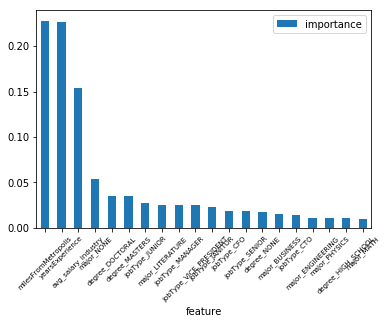

In [14]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
#linear models don't have feature_importances
    importances = [0]*len(train_L1_df.columns)
    
feature_importances = pd.DataFrame({'feature':train_L1_df.columns, 
                                        'importance':importances})
feature_importances.sort_values(by='importance', ascending=False,
                                    inplace=True)
    
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)
    
#create a plot
feature_importances[0:20].plot.bar(align='center')
plt.xticks(rotation=45, fontsize=7)
plt.show()
    
#Save model results as .txt file:
model_results(model, mean_mse[model], pred, feature_importances)

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data